In [ ]:
import pandas as pd
import numpy as np
import random
import ultimate
import itertools

In [2]:
# define card set
suits = ['Hearts', 'Diamonds', 'Clubs', 'Spades']
ranks = ['2', '3', '4', '5', '6', '7', '8', '9', '10', 'J', 'Q', 'K', 'A']
rank_values = {rank: i for i, rank in enumerate(ranks, start=2)}

deck = [{'rank': rank, 'suit': suit} for suit in suits for rank in ranks]

combinations = ["High Card", "One Pair", "Two Pair", "Three of a Kind", "Four of a Kind", 
                "Full House", "Straight", "Flush", "Straight Flush", "Royal Flush"]
combinations_values = {combination: i for i, combination in enumerate(combinations, start=1)}

winning_hands = ["High Card", "One Pair", "Two Pair", "Three of a Kind", "Straight", "Flush", 
                "Full House", "Four of a Kind", "Straight Flush", "Royal Flush"]

winning_hand_ranks = {hand: i for i, hand in enumerate(winning_hands)}
enumerated_deck = dict(enumerate(deck, start=1))
num_deck = list(range(1, 53))

In [3]:
enumerated_deck

{1: {'rank': '2', 'suit': 'Hearts'},
 2: {'rank': '3', 'suit': 'Hearts'},
 3: {'rank': '4', 'suit': 'Hearts'},
 4: {'rank': '5', 'suit': 'Hearts'},
 5: {'rank': '6', 'suit': 'Hearts'},
 6: {'rank': '7', 'suit': 'Hearts'},
 7: {'rank': '8', 'suit': 'Hearts'},
 8: {'rank': '9', 'suit': 'Hearts'},
 9: {'rank': '10', 'suit': 'Hearts'},
 10: {'rank': 'J', 'suit': 'Hearts'},
 11: {'rank': 'Q', 'suit': 'Hearts'},
 12: {'rank': 'K', 'suit': 'Hearts'},
 13: {'rank': 'A', 'suit': 'Hearts'},
 14: {'rank': '2', 'suit': 'Diamonds'},
 15: {'rank': '3', 'suit': 'Diamonds'},
 16: {'rank': '4', 'suit': 'Diamonds'},
 17: {'rank': '5', 'suit': 'Diamonds'},
 18: {'rank': '6', 'suit': 'Diamonds'},
 19: {'rank': '7', 'suit': 'Diamonds'},
 20: {'rank': '8', 'suit': 'Diamonds'},
 21: {'rank': '9', 'suit': 'Diamonds'},
 22: {'rank': '10', 'suit': 'Diamonds'},
 23: {'rank': 'J', 'suit': 'Diamonds'},
 24: {'rank': 'Q', 'suit': 'Diamonds'},
 25: {'rank': 'K', 'suit': 'Diamonds'},
 26: {'rank': 'A', 'suit': 'Diamo

In [4]:
def decide_game_victor_and_calculate_rewards_for_bets(row):
    
    player_hand = [enumerated_deck[card] for card in row[0:7]]
    dealer_hand = [enumerated_deck[card] for card in row[2:]]

    player_combination = ultimate.get_best_hand(player_hand)
    dealer_combination = ultimate.get_best_hand(dealer_hand)

    player_rank = winning_hand_ranks[player_combination]
    dealer_rank = winning_hand_ranks[dealer_combination]

    victor = 0 # 0 = dealer, 1 = player
    
    if player_rank > dealer_rank:
        victor = 1
    elif player_rank == dealer_rank:
        result = ultimate.decider(player_combination, player_hand, 
                                  dealer_combination, dealer_hand)
        if result == "player":
            victor = 1
        elif result == "dealer":	
            victor = 0
        else:
            victor = random.randint(0, 1)	# need to decide about this
    else:
        victor = 0

    # check if ante is valid
    dealer_has_something = ultimate.dealer_has_pair_or_better(dealer_hand[:2], dealer_hand[2:])
    blind_won = ultimate.has_blind(1, player_combination) - 1 #how much blind got us

    # calculate rewards for first and second rounds (in third victory is already bet, defeat is fold)
    first_round = 0
    second_round = 0
    third_round = 0

    # if its a draw, we leave both values at zero
    if victor == 1:
        first_round = 4 + blind_won + (1 if dealer_has_something else 0)
        second_round = 2 + blind_won + (1 if dealer_has_something else 0)
        third_round = 1 + blind_won + (1 if dealer_has_something else 0)
    elif victor == 0:
        first_round = -6 + (1 if not dealer_has_something else 0)
        second_round = -4 + (1 if not dealer_has_something else 0)
        third_round = -3 + (1 if not dealer_has_something else 0)
    
    return [first_round, second_round, third_round]

# function for conversion back to cards for checking
def convert_to_cards(row):
    cards = row[:9]
    output = [(enumerated_deck[card]["rank"], enumerated_deck[card]["suit"])  for card in cards]
    return output

In [7]:
all_starting_hands = list(itertools.combinations(num_deck, 2))
multiplier_D = 30
multiplier_1 = 30
multiplier_2 = 30

header = ["C1", "C2", "R1", "R2", "R3", "R4", "R5", "D1", "D2"]
rows = []

for idx, player in enumerate(all_starting_hands):
    player = list(player)  
    for _ in range(multiplier_1):
        remaining_deck = [card for card in num_deck if card not in player]
        flop = random.sample(remaining_deck, 3)
        for _ in range(multiplier_2):
            used = set(player + flop) 
            river = random.sample([card for card in num_deck if card not in used], 2)
            for _ in range(multiplier_D):
                used2 = set(player + flop + river)
                dealer = random.sample([card for card in num_deck if card not in used2], 2)
                rows.append(player + flop + river + dealer)

full_data_set = pd.DataFrame(rows, columns=header)
print("Generated all variables")

full_data_set[["Q1", "Q2", "Q3"]] = full_data_set.apply(
    decide_game_victor_and_calculate_rewards_for_bets, axis=1, result_type="expand"
)
print("Rewards calculated")

Generated all variables
Rewards calculated


In [7]:
def select_round_data(df, round_type):
    if round_type == "Q1":
        cols = ["C1", "C2", "Q1"]
    elif round_type == "Q2":
        cols = ["C1", "C2", "R1", "R2", "R3", "Q2"]
    elif round_type == "Q3":
        cols = ["C1", "C2", "R1", "R2", "R3", "R4", "R5",  "Q3"]
    return df[cols]

In [15]:
stats_Q1 = select_round_data(full_data_set, "Q1")
stats_Q2 = select_round_data(full_data_set, "Q2")
stats_Q3 = select_round_data(full_data_set, "Q3")

np.save("data_for_first_round.npy", stats_Q1.to_numpy())
np.save("data_for_second_round.npy", stats_Q2.to_numpy())
np.save("data_for_third_round.npy", stats_Q3.to_numpy())

In [17]:
print(stats_Q1.tail(100))

        C1  C2   Q1
165650  51  52  4.0
165651  51  52 -6.0
165652  51  52  4.0
165653  51  52 -6.0
165654  51  52 -6.0
...     ..  ..  ...
165745  51  52  5.0
165746  51  52  4.0
165747  51  52  5.0
165748  51  52  5.0
165749  51  52  5.0

[100 rows x 3 columns]


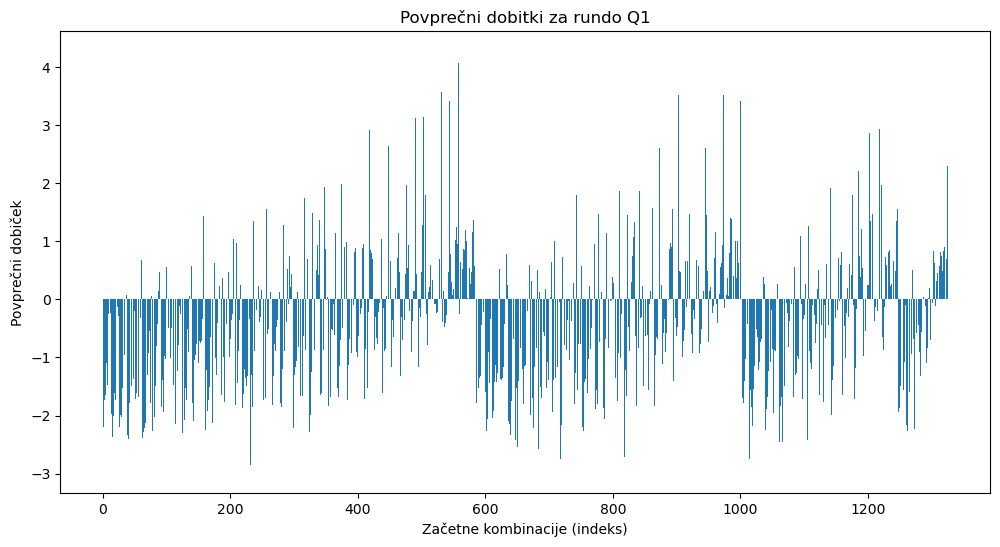

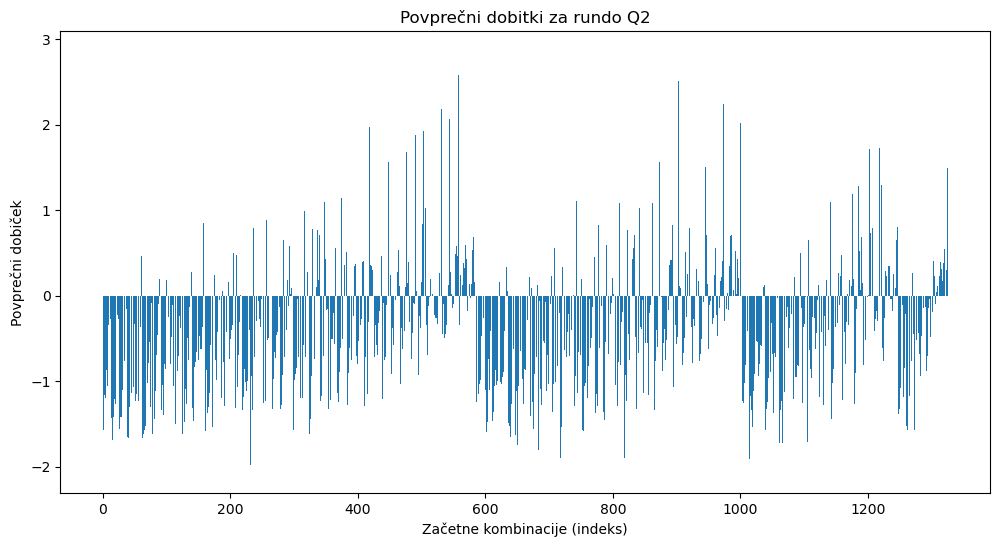

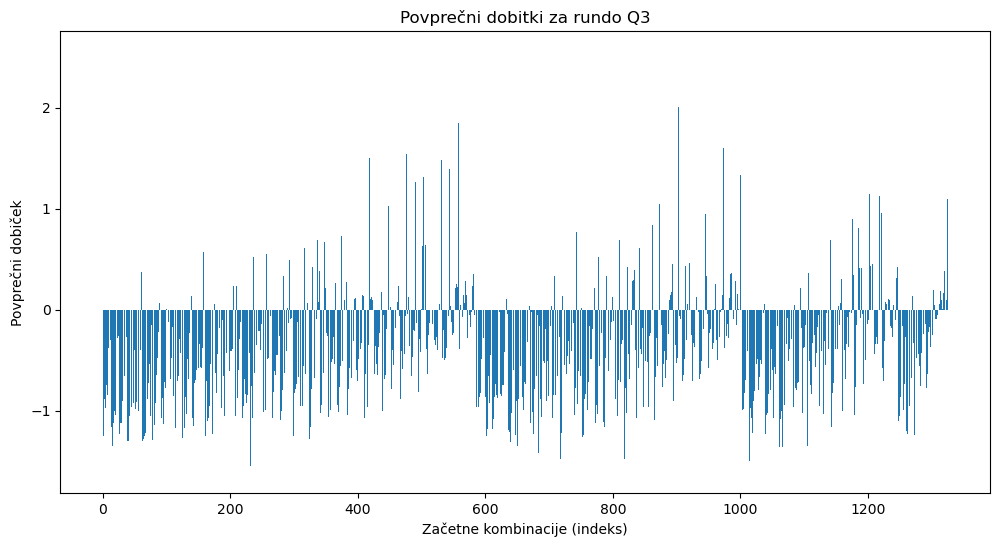

In [8]:
import matplotlib.pyplot as plt

# --- povprečni dobitki po kombinacijah in rundah ---
avg_rewards = (
    full_data_set.groupby(["C1", "C2"])[["Q1", "Q2", "Q3"]]
    .mean()
    .reset_index()
)

# --- nariši stolpčne diagrame ---
for round_name in ["Q1", "Q2", "Q3"]:
    plt.figure(figsize=(12, 6))
    avg_rewards.sort_values(by=round_name, ascending=False, inplace=True)
    plt.bar(
        avg_rewards.index, 
        avg_rewards[round_name], 
    )
    plt.title(f"Povprečni dobitki za rundo {round_name}")
    plt.xlabel("Začetne kombinacije (indeks)")
    plt.ylabel("Povprečni dobiček")
    plt.show()


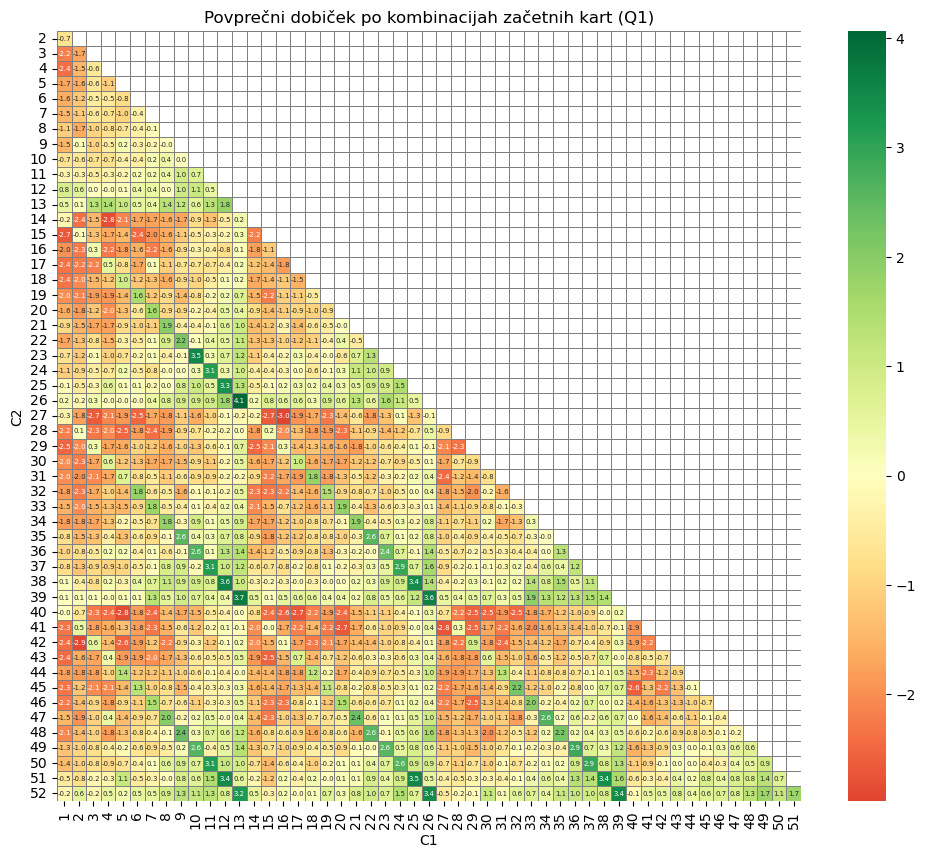

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

full_data_set_filtered = full_data_set[full_data_set["Q1"] <= 500].copy()
pivot = full_data_set_filtered.pivot_table(index="C2", columns="C1", values="Q1", aggfunc="mean")

plt.figure(figsize=(12, 10))
sns.heatmap(
    pivot,
    cmap="RdYlGn",
    center=0,
    linewidths=0.5,
    linecolor="gray",
    annot=True,
    fmt=".1f",
    annot_kws={"size": 5}   
)

plt.title("Povprečni dobiček po kombinacijah začetnih kart (Q1)")
plt.xlabel("C1")
plt.ylabel("C2")
plt.show()

In [18]:
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from typing import Tuple
import math

In [19]:
def pad_to_length(tensor_list, max_len=9):
    padded = nn.utils.rnn.pad_sequence(tensor_list, batch_first=True, padding_value=0)
    if padded.size(1) < max_len:
        pad_size = max_len - padded.size(1)
        padded = F.pad(padded, (0, pad_size), value=0)
    else:
        padded = padded[:, :max_len]
    return padded  # [B, max_len]

In [20]:
def process_round_data(npy_file, round_type, max_len=9):
    data = np.load(npy_file)

    if round_type == "Q1":
        x = data[:, :2]   # C1, C2
        y = data[:, 2]    # Q1
    elif round_type == "Q2":
        x = data[:, :5]   # C1, C2, R1, R2, R3
        y = data[:, 5]    # Q2
    elif round_type == "Q3":
        x = data[:, :7]   # C1, C2, R1..R5
        y = data[:, 7]    # Q3
    else:
        raise ValueError("Unknown round type")

    x_padded = np.zeros((x.shape[0], max_len), dtype=np.int64)
    x_padded[:, :x.shape[1]] = x

    x_tensor = torch.tensor(x_padded, dtype=torch.long)
    y_tensor = torch.tensor(y, dtype=torch.float)
    return x_tensor, y_tensor

In [21]:
x_first, y_first = process_round_data("data_for_first_round.npy", "Q1")
x_second, y_second = process_round_data("data_for_second_round.npy", "Q2")
x_third, y_third = process_round_data("data_for_third_round.npy", "Q3")

round_ids = torch.cat([
    torch.zeros(len(x_first), dtype=torch.long),
    torch.ones(len(x_second), dtype=torch.long),
    torch.full((len(x_third),), 2, dtype=torch.long)
])

x_all = torch.cat([x_first, x_second, x_third], dim=0)
y_all = torch.cat([y_first, y_second, y_third], dim=0)

dataset_all = TensorDataset(x_all, round_ids, y_all)
dataloader_all = DataLoader(dataset_all, batch_size=32, shuffle=True)

In [22]:
class SimpleUTHNet(nn.Module):
    """
    Poenostavljena mreža za Q1/Q2/Q3.
    Vhod:
      - x: LongTensor [B, T] (T=9), indeksi kart 0..52 (0 = PAD)
      - round_id: LongTensor [B], vrednosti {0,1,2}
    Izhod:
      - mu: FloatTensor [B]  (ocena pričakovane vrednosti)
      - std: FloatTensor [B] (ocena standardnega odklona, vedno > 0)
    Opis:
      - embedanje kart + (opcijsko) pozicijsko vgradnjo
      - enostavno povprečenje po tokenih (ignora PAD)
      - majhen MLP, ki napoveduje mu in log_sigma
    """
    def __init__(
        self,
        num_unique_cards: int = 52,
        d_model: int = 64,
        mlp_hidden: int = 128,
        dropout: float = 0.1,
        use_pos: bool = True,
    ):
        super().__init__()
        self.T = 9
        self.card_embed = nn.Embedding(num_unique_cards + 1, d_model, padding_idx=0)
        self.use_pos = use_pos
        if use_pos:
            self.pos_embed = nn.Embedding(self.T, d_model)

        # round embedding (0,1,2)
        self.round_embed = nn.Embedding(3, d_model)

        # small MLP head that outputs two vrednosti: mu in log_sigma
        self.mlp = nn.Sequential(
            nn.Linear(d_model, mlp_hidden),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_hidden, mlp_hidden // 2),
            nn.GELU(),
        )
        self.out_mu = nn.Linear(mlp_hidden // 2, 1)
        self.out_logsigma = nn.Linear(mlp_hidden // 2, 1)

    def forward(self, x: torch.LongTensor, round_id: torch.LongTensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Vrne (mu, std) kot [B], [B].
        """
        B, T = x.shape
        assert T == self.T, f"Expected sequence length {self.T}, got {T}"

        # embedding
        h = self.card_embed(x)                       # [B,T,D]
        if self.use_pos:
            pos = torch.arange(T, device=x.device).unsqueeze(0).expand(B, T)
            h = h + self.pos_embed(pos)
        # add round embedding broadcasted over tokens
        r = self.round_embed(round_id).unsqueeze(1)  # [B,1,D]
        h = h + r

        # mask PAD tokens and compute mean over non-pad tokens
        mask = (x != 0).unsqueeze(-1).float()        # [B,T,1]
        summed = (h * mask).sum(dim=1)              # [B,D]
        counts = mask.sum(dim=1).clamp(min=1.0)     # [B,1] avoid div by zero
        pooled = summed / counts                    # [B,D]

        # MLP head
        features = self.mlp(pooled)                 # [B, H]
        mu = self.out_mu(features).squeeze(-1)      # [B]
        log_sigma = self.out_logsigma(features).squeeze(-1)  # [B]

        # ensure positive std: use softplus on log_sigma (stable + >0)
        std = F.softplus(log_sigma) + 1e-6          # [B], small eps for numerical safety

        return mu, std


In [23]:
def train_model(
    model,
    train_loader,
    val_loader=None,
    num_epochs=10,
    lr=1e-3,
    device=None,
):
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(1, num_epochs + 1):
        model.train()
        total_loss = 0.0

        for x, round_id, y in train_loader:
            x = x.to(device)
            round_id = round_id.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            mu, std = model(x, round_id)        # forward
            var = std ** 2
            nll = 0.5 * (torch.log(2 * math.pi * var) + (y - mu)**2 / var)
            loss = nll.mean()                   # mean over batch
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * x.size(0)

        avg_loss = total_loss / len(train_loader.dataset)
        print(f"Epoch {epoch:03d}: Train NLL = {avg_loss:.6f}")

        # --- validation ---
        if val_loader is not None:
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for x, round_id, y in val_loader:
                    x = x.to(device)
                    round_id = round_id.to(device)
                    y = y.to(device)
                    mu, std = model(x, round_id)
                    var = std ** 2
                    nll = 0.5 * (torch.log(2 * math.pi * var) + (y - mu)**2 / var)
                    val_loss += nll.mean().item() * x.size(0)

            val_loss /= len(val_loader.dataset)
            print(f"           Val NLL = {val_loss:.6f}")

    return model

In [24]:
model = SimpleUTHNet()
trained_model = train_model(model, dataloader_all, num_epochs=3, lr=0.0001)

Epoch 001: Train NLL = 2.964297
Epoch 002: Train NLL = 2.841454
Epoch 003: Train NLL = 2.811732


In [25]:
def get_model_input_based_on_round(cards, round, max_len=9):
    """
    Prepare model input tensor for a given round.
    Returns: LongTensor [1, max_len]
    """
    if round == 0:      # Q1: C1,C2
        input_cards = cards[:2]
    elif round == 1:    # Q2: C1,C2,R1,R2,R3
        input_cards = cards[:5]
    else:               # Q3: C1,C2,R1..R5
        input_cards = cards[:7]

    input_tensor = torch.tensor(input_cards, dtype=torch.long)
    padded = F.pad(input_tensor, (0, max_len - len(input_tensor)), value=0)
    return padded.unsqueeze(0)  # shape: [1, max_len]

In [51]:
import torch
from torch import nn, optim

# thresholds parameter
thresholds = nn.Parameter(torch.tensor([0.0, 0.0, 0.0], dtype=torch.float, device="cuda" if torch.cuda.is_available() else "cpu"))
optimizer = optim.Adam([thresholds], lr=1e-4)

def soft_simulate_budget(model, games_batch, thresholds, device="cpu", steep=20):
    model.eval()
    total_budget = 0.0
    rewards_list = []

    for cards in games_batch:
        round_rewards = []
        for round_idx in range(3):
            x_input = get_model_input_based_on_round(cards, round_idx).to(device)
            round_id = torch.tensor([round_idx], dtype=torch.long, device=device)
            
            mu, std = model(x_input, round_id)   # use mu
            ev_tensor = mu.squeeze()             # scalar

            bet_prob = torch.sigmoid(steep * (ev_tensor - thresholds[round_idx]))
            
            # --- reward computation ---
            # poenostavljeno: dobiš +1 za win, -1 za lose (lahko se nadgradi)
            # tukaj vzamemo fiktivne nagrade za primer
            reward = bet_prob * (1.0 if ultimate_wins(cards) else -1.0)
            round_rewards.append(reward)

        round_rewards_tensor = torch.stack(round_rewards)
        total_budget += round_rewards_tensor.sum()
        rewards_list.append(round_rewards_tensor.sum())

    rewards_tensor = torch.stack(rewards_list)
    mean_reward = rewards_tensor.mean()
    std_reward = rewards_tensor.std(unbiased=False) + 1e-6
    sharpe_approx = mean_reward / std_reward

    return total_budget, sharpe_approx

# --- training loop ---
num_epochs = 10
games_batch = full_data_set[["C1","C2","R1","R2","R3","R4","R5","D1","D2"]].values.tolist()
device = "cuda" if torch.cuda.is_available() else "cpu"
thresholds = thresholds.to(device)

for epoch in range(num_epochs):
    optimizer.zero_grad()
    total_budget, sharpe = soft_simulate_budget(trained_model, games_batch, thresholds, device=device)
    
    loss = -sharpe  # maximize Sharpe
    loss.backward()
    optimizer.step()
    
    print(f"Epoch {epoch+1}: thresholds = {thresholds.data.tolist()}, Sharpe ≈ {sharpe.item():.4f}")



NameError: name 'ultimate_wins' is not defined

In [41]:
class UTHMultiRoundNet(nn.Module):
    def __init__(self, num_unique_cards=52, d_model=64, n_heads=2, depth=1, mlp_hidden=128, dropout=0.1):
        super().__init__()
        self.card_embed  = nn.Embedding(num_unique_cards+1, d_model, padding_idx=0)
        self.pos_embed   = nn.Embedding(9, d_model)
        self.round_embed = nn.Embedding(3, d_model)

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads,
                                                   dim_feedforward=4*d_model,
                                                   dropout=dropout, batch_first=True, activation="gelu")
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=depth)

        self.gate = nn.Sequential(nn.Linear(d_model, d_model), nn.GELU(), nn.Linear(d_model, 1))
        self.head = nn.Sequential(nn.Linear(d_model, mlp_hidden), nn.GELU(),
                                  nn.Dropout(dropout), nn.Linear(mlp_hidden, 2))  # output: mu, std

    def forward(self, x: torch.Tensor, round_id: torch.Tensor):
        B, T = x.shape
        key_padding_mask = (x==0)
        pos = torch.arange(T, device=x.device).unsqueeze(0).expand(B,T)
        h = self.card_embed(x) + self.pos_embed(pos) + self.round_embed(round_id).unsqueeze(1)
        h = self.encoder(h, src_key_padding_mask=key_padding_mask)
        gates = self.gate(h).squeeze(-1)
        gates = gates.masked_fill(key_padding_mask, -1e9)
        attn = torch.softmax(gates, dim=1).unsqueeze(-1)
        pooled = torch.sum(attn * h, dim=1)
        mu_std = self.head(pooled)  # [B,2]
        mu, std = mu_std[:,0], torch.nn.functional.softplus(mu_std[:,1]) + 1e-6
        return mu, std

# -------------------------
# 2️⃣ Train funkcija
# -------------------------
def train_model(model, train_loader, val_loader=None, num_epochs=10, lr=1e-3, device="cpu"):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    for epoch in range(1, num_epochs+1):
        model.train()
        total_loss = 0.0
        for x, round_id, y in train_loader:
            x, round_id, y = x.to(device), round_id.to(device), y.to(device)
            optimizer.zero_grad()
            mu, std = model(x, round_id)
            loss = criterion(mu, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * x.size(0)
        avg_loss = total_loss / len(train_loader.dataset)
        print(f"Epoch {epoch}: Train MSE = {avg_loss:.4f}")

        if val_loader is not None:
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for x, round_id, y in val_loader:
                    x, round_id, y = x.to(device), round_id.to(device), y.to(device)
                    mu, std = model(x, round_id)
                    val_loss += criterion(mu, y).item() * x.size(0)
            val_loss /= len(val_loader.dataset)
            print(f"           Val   MSE = {val_loss:.4f}")
    return model

In [28]:
model = UTHMultiRoundNet(d_model=64, n_heads=2, depth=1)
trained_model = train_model(model, dataloader_all, num_epochs=3, lr=0.0001)

Epoch 1: Train MSE = 24.2297
Epoch 2: Train MSE = 23.9394
Epoch 3: Train MSE = 23.6636


In [53]:
def test_model_with_games(model, num_games=100):
    model.eval()
    budget = 0
    allBet = 0
    folds = 0
    flops = 0
    rivers = 0
    preflops = 0

    preds = []

    for i in range(num_games):
        # generate game (9 cards, values 1-52)
        cards = random.sample(range(1, 53), 9)
        winnings = 0

        round_idx = 0
        round_when_bet = None

        while True:
            x_input = get_model_input_based_on_round(cards, round_idx)
            round_tensor = torch.tensor([round_idx], dtype=torch.long)

            with torch.no_grad():
                mu, std = model(x_input, round_tensor)

            # decision based on expected value / sharpe
            sharpe = mu / (std + 1e-6)
            bet_prob = torch.sigmoid(sharpe)
            preds.append(bet_prob.item())

            if bet_prob.item() > 0.4 and round_when_bet is None:
                round_when_bet = round_idx
                break

            round_idx += 1
            if round_idx == 3:
                break

        # --- izračun nagrade ---
        player_hand = [enumerated_deck[c] for c in cards[0:7]]
        dealer_hand = [enumerated_deck[c] for c in cards[2:]]

        player_comb = ultimate.get_best_hand(player_hand)
        dealer_comb = ultimate.get_best_hand(dealer_hand)

        player_rank = winning_hand_ranks[player_comb]
        dealer_rank = winning_hand_ranks[dealer_comb]

        victor = 0
        if player_rank > dealer_rank:
            victor = 1
        elif player_rank == dealer_rank:
            result = ultimate.decider(player_comb, player_hand, dealer_comb, dealer_hand)
            if result == "player":
                victor = 1
            elif result == "dealer":
                victor = 0
            else:
                victor = 2
                winnings = 0
        else:
            victor = 0

        dealer_has_something = ultimate.dealer_has_pair_or_better(dealer_hand[:2], dealer_hand[2:])
        blind_won = ultimate.has_blind(1, player_comb) - 1

        if round_when_bet == 0:
            winnings = 4 + blind_won + (1 if dealer_has_something else 0) if victor == 1 else -6
            allBet += 6
            preflops += 1
        elif round_when_bet == 1:
            winnings = 2 + blind_won + (1 if dealer_has_something else 0) if victor == 1 else -4
            allBet += 4
            flops += 1
        elif round_when_bet == 2:
            winnings = 1 + blind_won + (1 if dealer_has_something else 0) if victor == 1 else -3
            allBet += 3
            rivers += 1
        elif round_when_bet is None:
            winnings = -2
            allBet += 2
            folds += 1

        budget += winnings

    print("Budget is: ", budget)
    print("Betted: ", allBet)
    print("House edge: ", budget / allBet * 100, "%")
    print("PreFlops: ", preflops)
    print("Flops:", flops)
    print("Rivers:", rivers)
    print("Folds: ", folds)


In [54]:
test_model_with_games(trained_model, num_games=10000)

Budget is:  -8748.0
Betted:  38661
House edge:  -22.627454023434467 %
PreFlops:  4158
Flops: 888
Rivers: 253
Folds:  4701


In [64]:
def optimize_thresholds(model, num_games=100, num_epochs=50, device="cpu", steep=20):
    model.eval()
    thresholds = nn.Parameter(torch.zeros(3, device=device))
    optimizer = optim.Adam([thresholds], lr=0.01)

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        allBet = torch.zeros(1, device=device)       # 1-element tensor
        total_budget = torch.zeros(1, device=device) # 1-element tensor

        for _ in range(num_games):
            cards = random.sample(range(1, 53), 9)
            round_idx = 0
            round_rewards = []

            while round_idx < 3:
                x_input = get_model_input_based_on_round(cards, round_idx).to(device)
                round_tensor = torch.tensor([round_idx], dtype=torch.long, device=device)
                
                mu, std = model(x_input, round_tensor)
                sharpe = mu / (std + 1e-6)

                # soft decision: differentiable
                bet_prob = torch.sigmoid(steep * (sharpe - thresholds[round_idx]))

                # --- reward as differentiable function of bet_prob ---
                player_hand = [enumerated_deck[c] for c in cards[0:7]]
                dealer_hand = [enumerated_deck[c] for c in cards[2:]]

                player_comb = ultimate.get_best_hand(player_hand)
                dealer_comb = ultimate.get_best_hand(dealer_hand)

                player_rank = winning_hand_ranks[player_comb]
                dealer_rank = winning_hand_ranks[dealer_comb]

                victor = 0
                if player_rank > dealer_rank:
                    victor = 1
                elif player_rank == dealer_rank:
                    result = ultimate.decider(player_comb, player_hand, dealer_comb, dealer_hand)
                    if result == "player":
                        victor = 1
                    elif result == "dealer":
                        victor = 0
                    else:
                        victor = 2
                else:
                    victor = 0

                dealer_has_something = ultimate.dealer_has_pair_or_better(dealer_hand[:2], dealer_hand[2:])
                blind_won = ultimate.has_blind(1, player_comb) - 1

                # --- base reward per round ---
                base_reward_win = torch.tensor([4, 2, 1], dtype=torch.float, device=device)
                base_reward_loss = torch.tensor([-6, -4, -3], dtype=torch.float, device=device)

                reward = bet_prob * (base_reward_win[round_idx] if victor==1 else base_reward_loss[round_idx] + (1 if dealer_has_something else 0))
                round_rewards.append(reward)
                allBet += bet_prob  # soft sum of bets

                round_idx += 1

            total_budget += torch.stack(round_rewards).sum()

        loss = - total_budget / (allBet)  # maximize Sharpe approximation
        loss.backward()
        optimizer.step()

        print(f"Epoch {epoch+1}: thresholds = {thresholds.data.tolist()}, House edge ≈ {(total_budget / (allBet)).item():.4f}")

    return thresholds.data.tolist()



In [65]:
optimize_thresholds(model, num_games=1000, num_epochs=10, device="cpu", steep=10)

Epoch 1: thresholds = [0.009999998845160007, 0.009999998845160007, 0.009999998845160007], House edge ≈ -0.3103
Epoch 2: thresholds = [0.019833050668239594, 0.019890813156962395, 0.01992873288691044], House edge ≈ 0.0255
Epoch 3: thresholds = [0.02949121780693531, 0.029535584151744843, 0.029029643163084984], House edge ≈ -0.0511
Epoch 4: thresholds = [0.03904448822140694, 0.03911235183477402, 0.03845946863293648], House edge ≈ -0.1632
Epoch 5: thresholds = [0.048775363713502884, 0.048594869673252106, 0.04808076471090317], House edge ≈ 0.1050
Epoch 6: thresholds = [0.057935457676649094, 0.058232855051755905, 0.05762159451842308], House edge ≈ -0.1042
Epoch 7: thresholds = [0.06738796085119247, 0.06733202934265137, 0.06726612150669098], House edge ≈ -0.1187
Epoch 8: thresholds = [0.07695329189300537, 0.0766984075307846, 0.07708501815795898], House edge ≈ 0.0749
Epoch 9: thresholds = [0.08557937294244766, 0.08631566911935806, 0.08699191361665726], House edge ≈ 0.0447
Epoch 10: thresholds =

[0.09340129792690277, 0.09613671898841858, 0.09653273969888687]